# Evaluation for Generating Single Waveform

In [ ]:
import matplotlib.pyplot as plt
import os, sys
import torch
import logging
import torchaudio
import numpy as np

sys.path.append('./gm') # add your system path

from model.dvae import *
from get_data import min_max_norm

In [6]:
def restore_checkpoint(ckpt_dir, state, device='cuda'):
    if not os.path.exists(ckpt_dir):
        os.makedirs(os.path.dirname(ckpt_dir), exist_ok=True)
        logging.warning(f"No checkpoint found at {ckpt_dir}. "
                        f"Returned the same state as input")
        return state
    else:
        loaded_state = torch.load(ckpt_dir, map_location=device)['model']
        loaded_model_state = {}
        for k, v in loaded_state.items():
            if 'module' in k:
                loaded_model_state[k[7:]] = v
        state['model'].load_state_dict(loaded_model_state, strict=False)
        return state

In [ ]:
log_dir = './best_model.pt'

Define model parameters

In [8]:
fft_size, w_len, h_len = 160, 160, 46
device = 'cpu'
tcondvar = 2
z_dim, ncond, z_rnn_dim = 32, 16, 32

Normalization factors for conditional variables and waveforms

In [ ]:
norm_dict = {
    'mag': [1.09, 3.99],
    'src_lat': [36.7865, 38.5575],
    'src_lon': [-123.00267, -121.388],
    'sta_lat': [37.25898, 38.24731],
    'sta_lon': [-122.61573, -121.6413],
    'depth': [-0.21, 21.49],
    'log_wfs': [-10., 0.0569]
 }

In [ ]:
# setup the model
model = cVAE(
    in_dim = fft_size, 
    z_dim = z_dim, 
    ncond = ncond, 
    z_rnn_dim = z_rnn_dim, 
    in_size = len(norm_dict)-1).to(device)

state = dict(model = model)
state = restore_checkpoint(log_dir, state, device)
model = state['model']

wfs_min, wfs_max = norm_dict['log_wfs']
griffinlim = torchaudio.transforms.GriffinLim(
    n_fft = fft_size, 
    n_iter = 500, 
    win_length = w_len, 
    hop_length = h_len, 
    power = 1).to(device)

model.eval();

Define conditional variables

In [ ]:
cond_var_dict = {
    0: ['mag', 'rup', 'angle'],
    1: ['mag', 'rup', 'angle', 'depth'],
    2: ['mag', 'src_lat', 'src_lon', 'sta_lat', 'sta_lon', 'depth'],
    3: ['mag', 'depth'],
    4: ['mag', 'rup', 'depth'],
    5: ['mag', 'epi', 'depth']}

In [ ]:
def generate_single_wfs(model, cond_var, norm_dict, tcondvar=2, n_gens=1, device='cuda', seq_len=131, eps=1e-10):
    
    wfs_min, wfs_max = norm_dict['log_wfs']

    normalized_condvar = []
    for icvar, cvar in enumerate(cond_var_dict[tcondvar]):
        cv_min, cv_max = norm_dict[cvar]
        # normalized by min and max to [0, 1]
        cv = min_max_norm(cond_var[icvar], cv_min, cv_max, '[0,1]', 'sub')
        normalized_condvar.append(cv)
        
    normalized_condvar = torch.tensor(normalized_condvar).unsqueeze(0)

    with torch.no_grad():
        pred_wfss = []
        # generate n_gens random samples for each set of conditional variables
        for _ in range(n_gens):
            pred_wfs = model.generate(normalized_condvar.to(device).float(), seq_len)
            pred_wfs = pred_wfs.permute(0, 2, 1)
            pred_wfs = min_max_norm(pred_wfs, wfs_min, wfs_max, '[0,1]', 'add')
            pred_wfs = torch.pow(10, pred_wfs) - eps
            pred_wfs = griffinlim(pred_wfs)
            pred_wfss.append(pred_wfs.cpu().numpy())
            
        return np.stack(pred_wfss)

Define specific conditional variables

In [13]:
#'Magnitude', 'Source Lat', 'Source Lon', 'Station Lat', 'Station Lon', 'Depth (km)'
cond_var = [1.89, 37.95333, -122.07067, 37.95397, -121.86554, 10.49]

In [14]:
seq_len = 6000//h_len + 1
pred_wfss = generate_single_wfs(model, cond_var, norm_dict, n_gens=2, device=device, seq_len=seq_len)

In [15]:
rcolor = '#dd1c77'
pcolor = '#2c7fb8'
rlabel = 'Truth'
plabel = 'Generation'

Load true waveform (users can download it from data report)

In [16]:
true_wfs = np.load('true_wfs.npy')

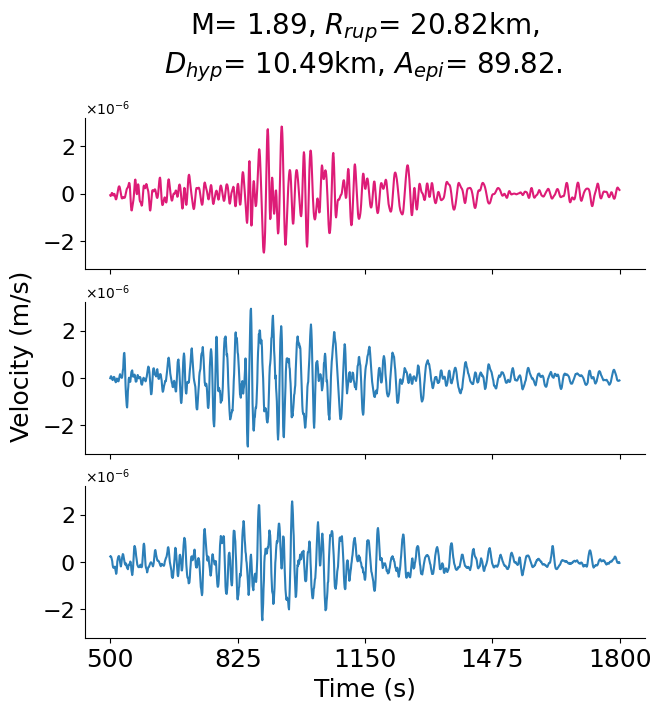

In [ ]:
ncols, nrows = 1, 3
colors = [rcolor, *[pcolor]*(nrows-1)]
labels = [rlabel, *[plabel]*(nrows-1)]

from matplotlib.ticker import ScalarFormatter

class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1d"
      
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, layout='constrained', figsize=(6.5, 7), gridspec_kw={'wspace': 0.05})  #1.75

rwfs = true_wfs.squeeze().tolist()
wfss = [rwfs, *[pred_wfss.squeeze()[i] for i in range(2)]] 

vmin, vmax = -4e-6, 4e-6

ticks = [v for v in [vmin, 0, vmax]]
ticklabels = [round(t, 2) for t in ticks]

for nrow in range(nrows):
    tbeg, tend = 5*100, 18*100
    axs[nrow].plot(wfss[nrow][tbeg:tend], color=colors[nrow], label=labels[nrow])
    axs[nrow].set_ylim(vmin, vmax)

    axs[nrow].yaxis.set_major_formatter(yScalarFormatter)
    axs[nrow].tick_params(axis='y', labelsize=16)
    axs[nrow].set_xticks(np.linspace(0, tend-tbeg, 5), np.linspace(tbeg, tend, 5, dtype=int))

    if nrow == nrows-1:
        axs[nrow].set_xticklabels(np.linspace(tbeg, tend, 5, dtype=int), fontsize=18)
        axs[nrow].set_xlabel('Time (s)', fontsize=18)
        axs[nrow].spines[['right', 'top']].set_visible(False)
    else:
        axs[nrow].set_xticklabels([])
        axs[nrow].spines[['right', 'top']].set_visible(False)
        
ang, rup = 89.82, 20.82
mag, dep = cond_var[0], cond_var[-1]
title = f'M= {mag}, ' + r'$R_{rup}$' + f'= {round(rup, 2)}km,\n' + r'$D_{hyp}$' + f'= {dep}km, '+ r'$A_{epi}$' + f'= {round(ang, 2)}. \n'
axs[0].set_title(title, fontsize=20)
fig.supylabel('Velocity (m/s)', fontsize=18);

## Multiple Waveforms

In [45]:
cond_vars = [[1.89, 37.95333, -122.07067, 37.95397, -121.86554, 10.49], [2.8, 37.3005, -122.13767, 37.40373, -122.23868, 10.0]]
all_pred_wfss = []
for cond_var in cond_vars:
    pred_wfss = generate_single_wfs(model, cond_var, norm_dict, n_gens=2, device=device, seq_len=seq_len)
    all_pred_wfss.append(pred_wfss)

In [46]:
true_wfs2 = np.load('true_wfs2.npy')

In [47]:
tbegs, tends = [500, 0], [1800, 1500]

In [48]:
title_infos = [[1.89, 20.82, 10.49, 89.82],
               [2.80, 17.65, 10.00, -44.38]]

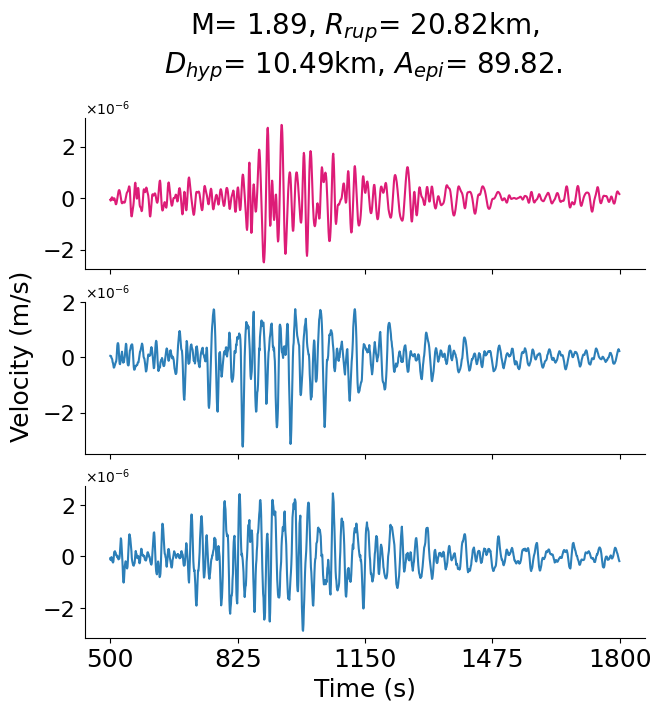

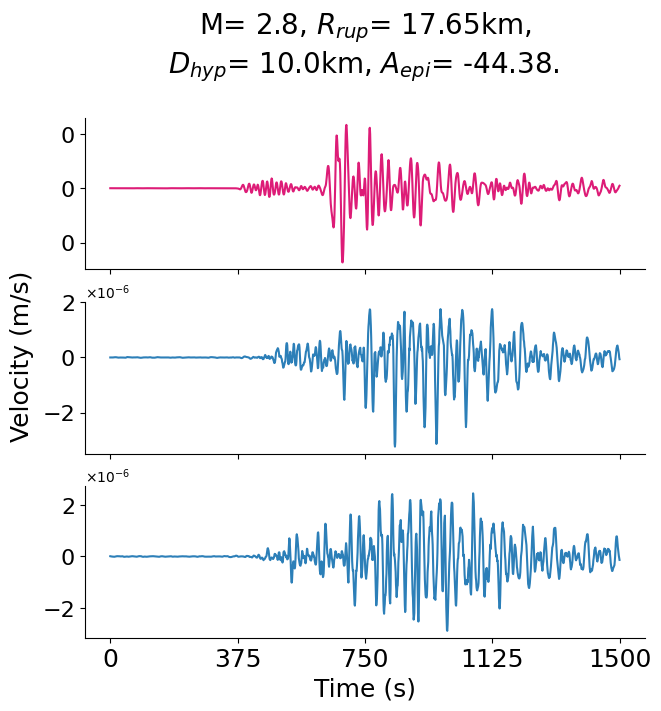

In [ ]:
for idx, (t_wfs, pred_wfss) in enumerate(zip([true_wfs, true_wfs2], all_pred_wfss)):
    ncols, nrows = 1, 3
    colors = [rcolor, *[pcolor]*(nrows-1)]
    labels = [rlabel, *[plabel]*(nrows-1)]

    from matplotlib.ticker import ScalarFormatter
    class ScalarFormatterClass(ScalarFormatter):
        def _set_format(self):
            self.format = "%1d"
        yScalarFormatter = ScalarFormatterClass(useMathText=True)
        yScalarFormatter.set_powerlimits((0,0))

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, layout='constrained', figsize=(6.5, 7), gridspec_kw={'wspace': 0.05})  #1.75

    rwfs = t_wfs.squeeze().tolist()
    wfss = [rwfs, *[all_pred_wfss[0].squeeze()[i] for i in range(2)]] 

    # vmin, vmax = -4e-6, 4e-6

    # ticks = [v for v in [vmin, 0, vmax]]
    # ticklabels = [round(t, 2) for t in ticks]

    for nrow in range(nrows):
        tbeg, tend = tbegs[idx], tends[idx]
        axs[nrow].plot(wfss[nrow][tbeg:tend], color=colors[nrow], label=labels[nrow])
        # axs[nrow].set_ylim(vmin, vmax)

        axs[nrow].yaxis.set_major_formatter(yScalarFormatter)
        axs[nrow].tick_params(axis='y', labelsize=16)
        axs[nrow].set_xticks(np.linspace(0, tend-tbeg, 5), np.linspace(tbeg, tend, 5, dtype=int))

        if nrow == nrows-1:
            axs[nrow].set_xticklabels(np.linspace(tbeg, tend, 5, dtype=int), fontsize=18)
            axs[nrow].set_xlabel('Time (s)', fontsize=18)
            axs[nrow].spines[['right', 'top']].set_visible(False)
        else:
            axs[nrow].set_xticklabels([])
            
            axs[nrow].spines[['right', 'top']].set_visible(False)
    mag, rup, dep, ang = title_infos[idx]
    title = f'M= {mag}, ' + r'$R_{rup}$' + f'= {round(rup, 2)}km,\n' + r'$D_{hyp}$' + f'= {dep}km, '+ r'$A_{epi}$' + f'= {round(ang, 2)}. \n'
    axs[0].set_title(title, fontsize=20)
    fig.supylabel('Velocity (m/s)', fontsize=18);
    plt.show()